In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%pylab inline

caffe_root = '//home/eustinova/caffe-caffe-0.14/'  # this file is expected to be in {caffe_root}/examples/siamese
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
root = '/home/eustinova/scripts/'  # this file is expected to be in {caffe_root}/examples/siameseimport sys
sys.path.insert(0, root)
from caffe.io import caffe_pb2
import caffe.io 
import generate_datasets as gen
import check_net as chn
import random
import lmdb
import struct

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [2]:
def parseRecord(val):
        int_size = 4;
        curr_start = 0;
        curr_end = 0;
        fields = []
        while (curr_start < len(val)):
            field_len = struct.unpack('I', val[curr_start : curr_start+int_size])[0]
            curr_start += int_size
            curr_end = curr_start + field_len

            field_datum = caffe_pb2.Datum.FromString(val[curr_start:curr_end])
            field_arr = caffe.io.datum_to_array(field_datum)
            curr_start = curr_end
            fields.append(field_arr)
        return fields

In [3]:
def getImagesAndLabels(path, keys):    
    env = lmdb.open(path, readonly=True) 
    descriptors = list();
    images = list()
    labels = list()
    
    count = 0;
   
    with env.begin() as txn:
        for k in keys:
            value = txn.get(k)
           
            try :
                datum = caffe_pb2.Datum.FromString(value)
                arr = caffe.io.datum_to_array(datum)
                
                label = datum.label
            except :
                arr = parseRecord(value)[0]
                label = parseRecord(value)[2][0][0][0]
                
                
            images.append(np.copy(arr)*1.0/256);
            labels.append(label)    
            #fields = parseRecord(value)
            #ims.append(np.copy(fields[0])*1.0/255);
            #labels.append(fields[2])
            count +=1;             


    return images, labels  

In [4]:
def randomBatchMaker(path, batch_size):
    key_set= set()
    env = lmdb.open(path)    
    with env.begin() as txn:
        cursor = txn.cursor()
        for k, v in cursor :
            key_set.add(k)
            
    batch_keys  = random.sample(key_set, batch_size)
    
    return batch_keys

In [49]:

#for k in xrange(len(labels))

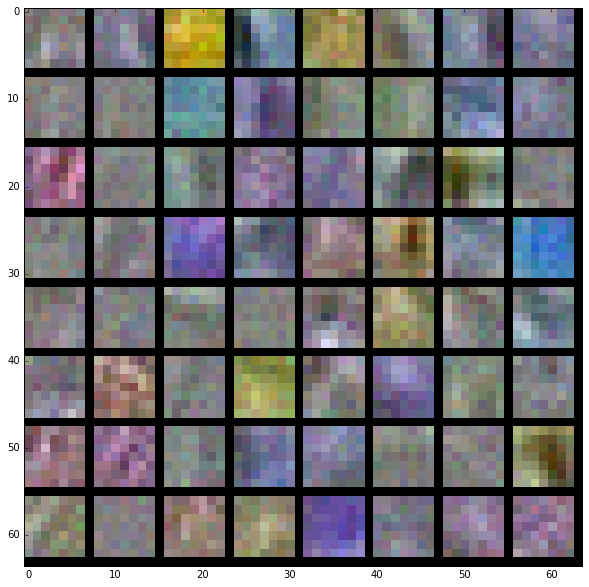

In [50]:
folder = '///media/storage/eustinova/CUHK03_bn/cuhk03_labeled_split1_batch_pos_neg_128_wo_too_hard_0.6//'

MODEL_FILE = folder + 'protos/train_val_model_debug.prototxt'

PRETRAINED_FILE = folder + '//snapshots/train_iter_30000.caffemodel'
rankgrid = np.append([1],np.arange(5, 200, 5))
caffe.set_mode_gpu()#net.set_phase_test()
net = caffe.Classifier(MODEL_FILE, PRETRAINED_FILE)
filters = net.params['conv1_1_2'][0].data 

plt.rcParams['figure.figsize'] = (10, 10)
chn.vis_square(filters.transpose(0, 2, 3, 1))

In [162]:
for k, data in net.blobs.items():
    print k, data.data.shape, data.num


data (128, 9, 60, 60) 128
reid_label (128, 1, 1, 1) 128
elim_data (8128, 1, 1, 1) 8128
reid_label_input_1_split_0 (128, 1, 1, 1) 128
reid_label_input_1_split_1 (128, 1, 1, 1) 128
data1_1 (128, 3, 60, 60) 128
data1_2 (128, 3, 60, 60) 128
data1_3 (128, 3, 60, 60) 128
conv1_1_1 (128, 64, 60, 60) 128
conv1_1_2 (128, 64, 60, 60) 128
conv1_1_3 (128, 64, 60, 60) 128
pool1_1_1 (128, 64, 30, 30) 128
pool1_1_2 (128, 64, 30, 30) 128
pool1_1_3 (128, 64, 30, 30) 128
conv2_1_1 (128, 64, 30, 30) 128
conv2_1_2 (128, 64, 30, 30) 128
conv2_1_3 (128, 64, 30, 30) 128
pool2_1_1 (128, 64, 15, 15) 128
pool2_1_2 (128, 64, 15, 15) 128
pool2_1_3 (128, 64, 15, 15) 128
pool2_1 (128, 192, 15, 15) 128
ip1_reid (128, 500) 128
ip1_reid_ip1_reid_0_split_0 (128, 500) 128
ip1_reid_ip1_reid_0_split_1 (128, 500) 128
cosine_neg (8128, 1, 1, 1) 8128
sim_neg (8128, 1, 1, 1) 8128
elim_neg (8128, 1, 1, 1) 8128
elim_neg_data (8128, 1, 1, 1) 8128
loss_neg () 1
cosine_pos (8128, 1, 1, 1) 8128
sim_pos (8128, 1, 1, 1) 8128
elim_pos

In [177]:
path = "/media/hpc2_storage/eustinova/segmentation/lmdb/cuhk03_160_60_3_parts/train_1160_no_aug"
batch_keys = randomBatchMaker(path, batch_size=128)
images, labels  = getImagesAndLabels(path, batch_keys)
bs = 128#128
bs_=bs*(bs-1)/2#8128

elimination_vector = np.ones((bs_, 1,1,1))
images=np.array(images[:bs])
labels=np.array(labels[:bs]).reshape(bs, 1,1,1)

In [178]:
net.blobs['data'].reshape(bs, 9, 60, 60)
net.blobs['reid_label'].reshape(bs,1,1,1)
net.blobs['elim_data'].reshape(bs_,1,1,1)


In [179]:
a = net.forward(data=np.array(images), reid_label=np.array(labels),
                    elim_data=np.array(elimination_vector),  
                blobs = ['cosine_pos', 'loss_pos', 'sim_pos', 'elim_pos',
                        'cosine_neg', 'loss_neg', 'sim_neg', 'elim_neg',
                        'elim_neg_data'])
print a['loss_neg']
elimination_vector_neg_hard = np.ones((bs_, 1,1,1))
k = 0
for i in xrange(bs):
     for j in xrange(i+1, bs):
          
            if a['cosine_neg'].reshape(bs_)[k] > 0.6:
                elimination_vector_neg_hard[k] = 0
            k+=1
            
            
a = net.forward(data=np.array(images), reid_label=np.array(labels),
                    elim_data=np.array(elimination_vector_neg_hard),  
                blobs = ['cosine_pos', 'loss_pos', 'sim_pos', 'elim_pos',
                        'cosine_neg', 'loss_neg', 'sim_neg', 'elim_neg',
                        'elim_neg_data'])            
print a['loss_neg']

reid_label (128, 1, 1, 1) <caffe._caffe.IntVec object at 0x7f2443cb84d0>
data (128, 9, 60, 60) <caffe._caffe.IntVec object at 0x7f2443cb84d0>
elim_data (8128, 1, 1, 1) <caffe._caffe.IntVec object at 0x7f2443cb84d0>
0.224093854427
reid_label (128, 1, 1, 1) <caffe._caffe.IntVec object at 0x7f2443cb8750>
data (128, 9, 60, 60) <caffe._caffe.IntVec object at 0x7f2443cb8750>
elim_data (8128, 1, 1, 1) <caffe._caffe.IntVec object at 0x7f2443cb8750>
0.173690825701


In [180]:
a['loss_neg']

array(0.1736908257007599, dtype=float32)

In [181]:
a['loss_neg']

array(0.1736908257007599, dtype=float32)

In [182]:
a['loss_pos']

array(0.3576999306678772, dtype=float32)

In [187]:
[i for i in xrange(len(a)) if a['elim_pos'][i] == 1]

[]

In [194]:
sum(a['cosine_pos'].reshape(bs_) * a['elim_pos'].reshape(bs_))/sum( a['elim_pos'])

0.92276895

(array([  8.12300000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.00000000e+00]),
 array([ 0.        ,  0.09699317,  0.19398633,  0.2909795 ,  0.38797266,
         0.48496583,  0.581959  ,  0.67895216,  0.77594533,  0.8729385 ,
         0.96993166]),
 <a list of 10 Patch objects>)

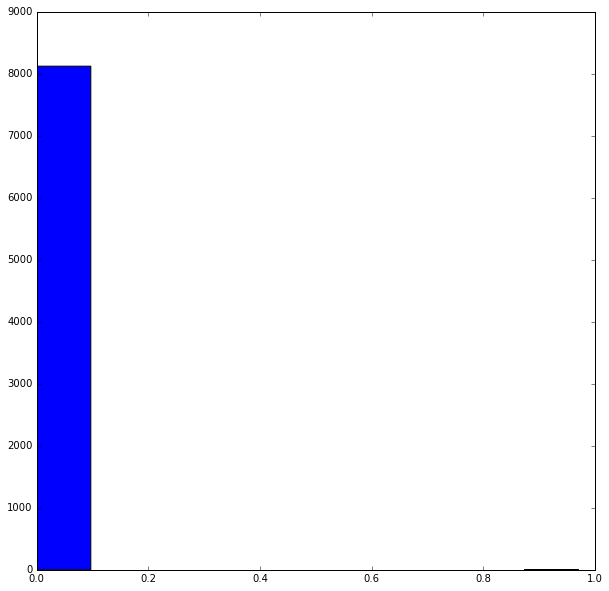

In [195]:
pylab.hist(a['cosine_pos'].reshape(bs_) * a['elim_pos'].reshape(bs_))

(array([   57.,   308.,   957.,  1723.,  1903.,  1414.,   919.,   521.,
          269.,    57.]),
 array([-0.83691275, -0.65642027, -0.47592779, -0.29543532, -0.11494284,
         0.06554964,  0.24604212,  0.4265346 ,  0.60702708,  0.78751956,
         0.96801203]),
 <a list of 10 Patch objects>)

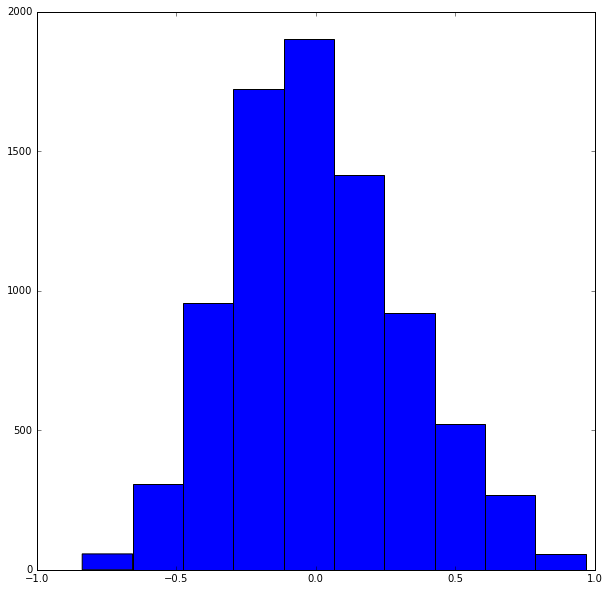

In [184]:
pylab.hist(a['cosine_neg'].reshape(bs_) * a['elim_neg'].reshape(bs_))

(array([   18.,    94.,   299.,   610.,  1038.,  1248.,  2203.,  1122.,
          831.,   665.]),
 array([-0.8540405 , -0.72864833, -0.60325615, -0.47786398, -0.3524718 ,
        -0.22707963, -0.10168746,  0.02370472,  0.14909689,  0.27448907,
         0.39988124]),
 <a list of 10 Patch objects>)

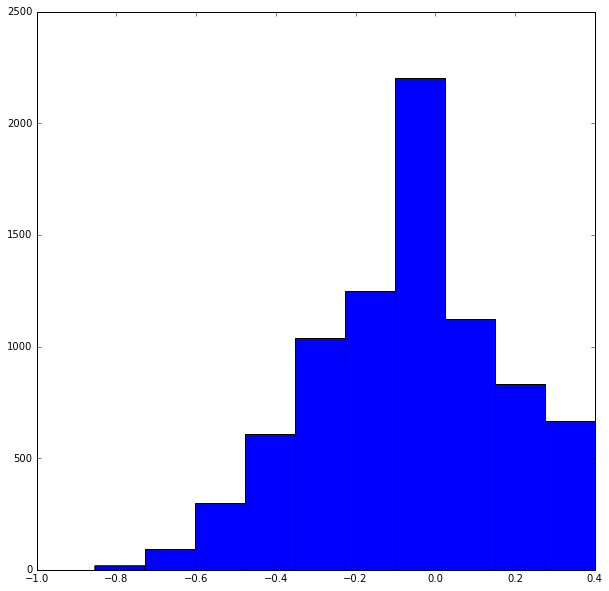

In [142]:
pylab.hist(a['cosine_neg'].reshape(bs_)*elimination_vector_neg_hard.reshape(bs_))

In [139]:
elimination_vector_neg_hard = np.ones((bs_, 1,1,1))
k = 0
for i in xrange(bs):
     for j in xrange(i+1, bs):
          
            if a['cosine_neg'].reshape(bs_)[k] > 0.4:
                elimination_vector_neg_hard[k] = 0
            k+=1

In [140]:
elimination_vector_neg_hard

array([[[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       ..., 
       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]]])

In [120]:
for i in xrange(bs_):
    if a['elim_neg_data'][i] != a['elim_neg'][i] * elimination_vector[i]:
        print i

In [137]:
np.all(a['elim_neg_data'] == a['elim_neg'] * elimination_vector_neg_hard)

True

In [133]:
elimination_vector = np.ones((bs_, 1,1,1))
k = 0
for i in xrange(bs):
     for j in xrange(i+1, bs):
           # if k in [0,313,660,2772,3056,3993,4339,4674,4779]:
            #    print labels[i], labels[j],a['elim_neg'][k] 
            if labels[i] == labels[j]:
                elimination_vector[k] = 0
            k+=1

In [135]:
np.all(a['elim_neg'] == elimination_vector_neg_hard)

False

In [111]:
for i in xrange(bs_):
    if a['elim_neg'][i] != elimination_vector[i]:
        print i

In [95]:
a['elim_neg'] 

array([[[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],


       [[[ 1.]]],




In [188]:
elimination_vector = np.ones((bs_, 1,1,1))
k = 0
for i in xrange(bs):
     for j in xrange(i+1, bs):
           # if k in [0,313,660,2772,3056,3993,4339,4674,4779]:
            #    print labels[i], labels[j],a['elim_neg'][k] 
            if labels[i] != labels[j]:
                elimination_vector[k] = 0
            k+=1

In [189]:
for i in xrange(bs_):
    if a['elim_pos'][i] != elimination_vector[i]:
        print i

In [191]:
1 in a['elim_pos']

True